In [3]:
from api_call import *
service = get_gmail_service()

get_all_emails_and_save_as_json(service)
# get_emails_after_date(service, datetime(2024, 3, 20))

Total number of messages: 2541


Processing emails: 100%|██████████| 2541/2541 [07:44<00:00,  5.47it/s]  


In [46]:
import re
import json
from utils import fecDatabaseUtil
# helper function to extract email addresses from string
def extract_email_addresses(str):
    email_pattern = re.compile(r'<([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)>')
    emails = email_pattern.findall(str)
    # if no email address was found, return the original string
    if len(emails) == 0:
        return str
    return emails[0]

candidates_and_emails = '../data/Candidates_Emails.json'
with open(candidates_and_emails, 'r', encoding='utf-8') as email_book:
    candidate_email_dict = json.load(email_book)

# Create an empty dictionary
email_content_dict = {}
emails_all = []
with open('../data/emails_extracted.json', 'r', encoding='utf-8') as json_file:
    emails_all = json.load(json_file)

count = 0
# Iterate through all emails
for email in emails_all:
    # # Use email address as key and content as value
    # if extract_email_addresses(email['from']) not in email_content_dict:
    #     email_content_dict[extract_email_addresses(email['from'])] = []
    # email_content_dict[extract_email_addresses(email['from'])].append(email['content_plain'])
    input = extract_email_addresses(email['from'])
    
    for candidate in candidate_email_dict: 
        if input in candidate['Emails']: 
            emails_all[count]['State'] = candidate['state']
            emails_all[count]['party'] = candidate['party']
            break

        emails_all[count]['State'] = 'unknown'
        emails_all[count]['party'] = 'unknown'
    
    count += 1

with open('../data/emails_extracted.json', 'w', encoding='utf-8') as email_book:
        # Dump the updated dictionary back into the JSON file
        json.dump(emails_all, email_book, ensure_ascii=False, indent=4)


In [47]:
import json

# Load the JSON data from the file
with open('../data/emails_extracted.json', 'r') as file:
    data = json.load(file)

# Define the lists of political words and figures to count
political_words = ['democrats', 'republicans', 'senate', 'gop', 'fundraising', 'resources', 'vote', 'majority', 'election', 'nevada', 'goal', 'campaign', 'grassroots', 'pac', 'missouri', 'senator', 'contribute', 'donation', 'gun', 'rights']
political_figures = ['trump', 'biden', 'obama', 'clinton', 'pelosi', 'mcconnell', 'sanders', 'harris', 'pence', 'romney', 'bush', 'cruz', 'warren', 'soros', 'koch', 'putin', 'xi', 'kim', 'merkel', 'macron', 'trudeau', 'modi', 'abe', 'erdogan']

import json

# Assuming the data has been loaded into `data`, and the lists `political_words` and `political_figures` are defined as before

# Function to count occurrences of each political word and figure in a text
def count_individual_mentions(text, search_terms):
    # Normalize text to lower case for case-insensitive matching
    text = text.lower()
    # Count occurrences of each term and return a dictionary of counts
    return {term: text.count(term) for term in search_terms}

# Add individual word and figures count for each entry
for entry in data:
    # Assuming 'content_plain' contains the text to analyze
    content = entry.get('content_plain', '')
    entry['word_counts'] = count_individual_mentions(content, political_words)
    entry['figure_counts'] = count_individual_mentions(content, political_figures)

with open('../data/emails_extracted.json', 'w', encoding='utf-8') as email_book:
        # Dump the updated dictionary back into the JSON file
        json.dump(data, email_book, ensure_ascii=False, indent=4)



In [10]:
import os
from bs4 import BeautifulSoup, Comment

json_file_path = '../data/emails_extracted.json'
with open(json_file_path, 'r', encoding='utf-8') as json_file:
    emails_all = json.load(json_file)

output_text_file_path = '../data/email_contents_plain.txt'
if os.path.exists(output_text_file_path):
    os.remove(output_text_file_path)  # Remove the file if it already exists

# Process the mbox and write email contents to a text file
for detail in emails_all:
    with open(output_text_file_path, 'a', encoding='utf-8') as file:
        if detail['content_plain'] and detail['content_plain'] != "":
            # remove empty lines
            detail['content_plain'] = '\n'.join([line for line in detail['content_plain'].split('\n') if line.strip() != ''])
            file.write(detail['content_plain'] + '\n\n')
        # if detail['content_html']:
        #     bs = BeautifulSoup(detail['content_html'], 'html.parser')

        #     # Remove <script> and <style> tags and their contents
        #     for script in bs(["script", "style"]):
        #         script.decompose()

        #     # Remove comments
        #     for comment in bs.findAll(text=lambda text: isinstance(text, Comment)):
        #         comment.extract()

        #     raw_text = bs.get_text()
        #     # remove empty lines
        #     raw_text = '\n'.join([line for line in raw_text.split('\n') if line.strip() != ''])
        #     file.write(raw_text + '\n\n')
        file.write('=========================================\n\n') # Separate emails with a line

In [ ]:
import os
from bs4 import BeautifulSoup, Comment

json_file_path = '../data/emails_extracted.json'
with open(json_file_path, 'r', encoding='utf-8') as json_file:
    emails_all = json.load(json_file)

output_text_file_path = '../data/email_url.txt'
if os.path.exists(output_text_file_path):
    os.remove(output_text_file_path)  # Remove the file if it already exists

# Process the mbox and write email contents to a text file
for detail in emails_all:
    with open(output_text_file_path, 'a', encoding='utf-8') as file:
        if detail['urls']:
            # remove empty lines
            detail['urls'] = '\n'.join([line for line in detail['content_plain'].split('\n') if line.strip() != ''])
            file.write(detail['content_plain'] + '\n\n')
        # if detail['content_html']:
        #     bs = BeautifulSoup(detail['content_html'], 'html.parser')

        #     # Remove <script> and <style> tags and their contents
        #     for script in bs(["script", "style"]):
        #         script.decompose()

        #     # Remove comments
        #     for comment in bs.findAll(text=lambda text: isinstance(text, Comment)):
        #         comment.extract()

        #     raw_text = bs.get_text()
        #     # remove empty lines
        #     raw_text = '\n'.join([line for line in raw_text.split('\n') if line.strip() != ''])
        #     file.write(raw_text + '\n\n')
        file.write('=========================================\n\n') # Separate emails with a line

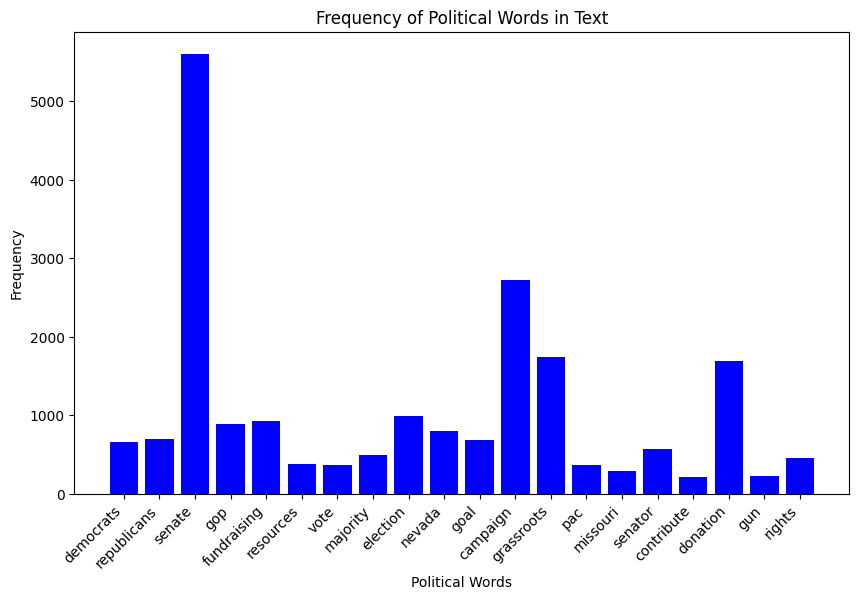

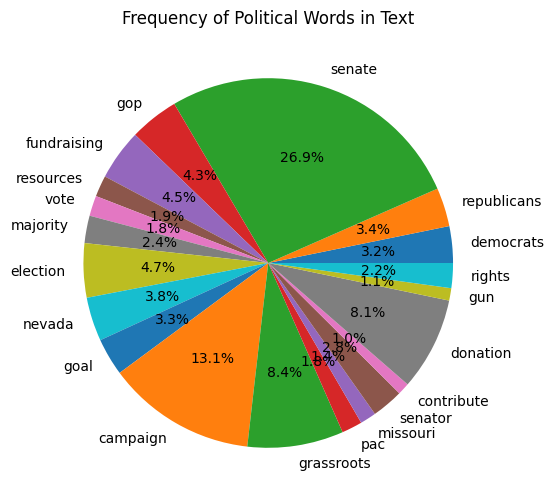

In [19]:
from matplotlib import pyplot as plt

political_words = ['democrats', 'republicans', 'senate', 'gop', 'fundraising', 'resources', 'vote', 'majority', 'election', 'nevada',  'goal', 'campaign', 'grassroots', 'pac', 'missouri', 'senator', 'contribute', 'donation', 'gun', 'rights']

# Load the provided text to scan for these words
text_path = "../data/email_contents_plain.txt"
with open(text_path, 'r', encoding='utf-8') as file:
    str = file.read().lower()  # Convert text to lowercase to match case-insensitively

# Tokenize the text and count the frequency of each political word
from collections import Counter
word_counts = Counter(str.split())
political_word_frequencies = {word: word_counts[word] for word in political_words if word in word_counts}

# Extract words and their frequencies for plotting
words = list(political_word_frequencies.keys())
frequencies = list(political_word_frequencies.values())

plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='blue')
plt.xlabel('Political Words')
plt.ylabel('Frequency')
plt.title('Frequency of Political Words in Text')
plt.xticks(rotation=45, ha="right")
# save the bar chart
plt.savefig('../result/political_words_bar_chart.png')
plt.show()
# pie chart
plt.figure(figsize=(10, 6))
plt.pie(frequencies, labels=words, autopct='%1.1f%%')
plt.title('Frequency of Political Words in Text')
# save the pie chart
plt.savefig('../result/political_words_pie_chart.png')
plt.show()

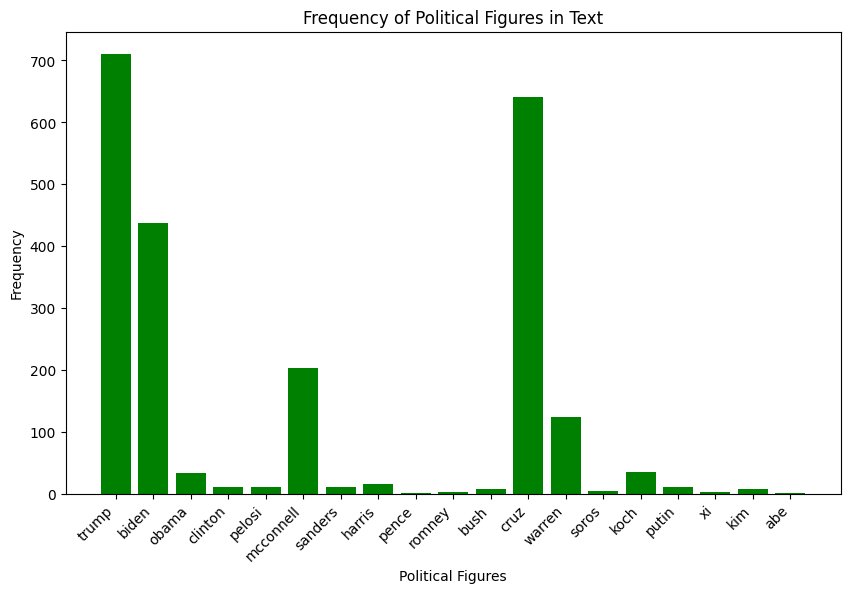

<Figure size 1000x600 with 0 Axes>

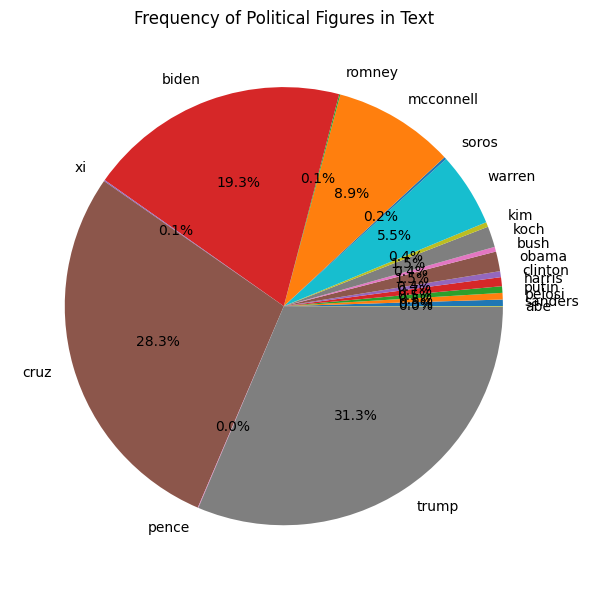

In [42]:
political_figures = ['trump', 'biden', 'obama', 'clinton', 'pelosi', 'mcconnell', 'sanders', 'harris', 'pence', 'romney', 'bush', 'cruz', 'warren', 'soros', 'koch', 'soros', 'koch', 'putin', 'xi', 'kim', 'merkel', 'macron', 'trudeau', 'modi', 'abe', 'erdogan']
political_figures = [figure.lower() for figure in political_figures]
political_figures_frequencies = {figure: word_counts[figure] for figure in political_figures if figure in word_counts}

# Extract figures and their frequencies for plotting
figures = list(political_figures_frequencies.keys())
frequencies = list(political_figures_frequencies.values())

sorted_figures_frequencies = sorted(zip(figures, frequencies), key=lambda x: x[1], reverse=True)
adjusted_figures = []
adjusted_frequencies = []
for i in range(len(sorted_figures_frequencies)):
    if i % 2 == 0:
        adjusted_figures.append(sorted_figures_frequencies[len(sorted_figures_frequencies)//2 + i//2][0])
        adjusted_frequencies.append(sorted_figures_frequencies[len(sorted_figures_frequencies)//2 + i//2][1])
    else:
        adjusted_figures.append(sorted_figures_frequencies[len(sorted_figures_frequencies)//2 - (i//2 + 1)][0])
        adjusted_frequencies.append(sorted_figures_frequencies[len(sorted_figures_frequencies)//2 - (i//2 + 1)][1])

plt.figure(figsize=(10, 6))
plt.bar(figures, frequencies, color='green')
plt.xlabel('Political Figures')
plt.ylabel('Frequency')
plt.title('Frequency of Political Figures in Text')
plt.xticks(rotation=45, ha="right")
# save the bar chart
plt.savefig('../result/political_figures_bar_chart.png')
plt.show()
plt.figure(figsize=(10, 6))
# pie chart
plt.figure(figsize=(10, 6))
# plt.pie(frequencies, labels=figures, autopct='%1.1f%%')
plt.pie(adjusted_frequencies, labels=adjusted_figures, autopct='%1.1f%%')
plt.title('Frequency of Political Figures in Text')
plt.tight_layout()
# save the pie chart
plt.savefig('../result/political_figures_pie_chart.png')
plt.show()

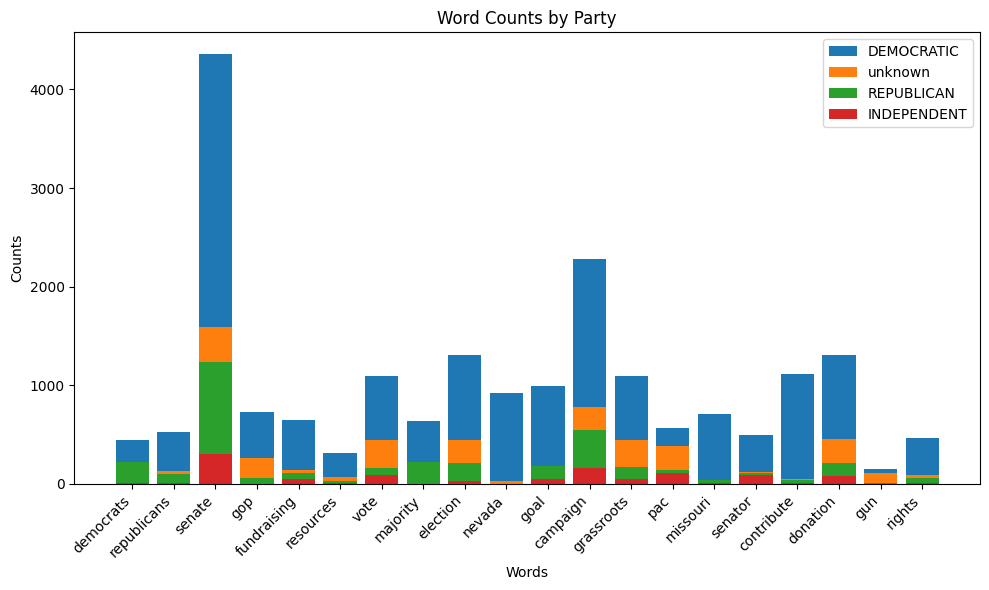

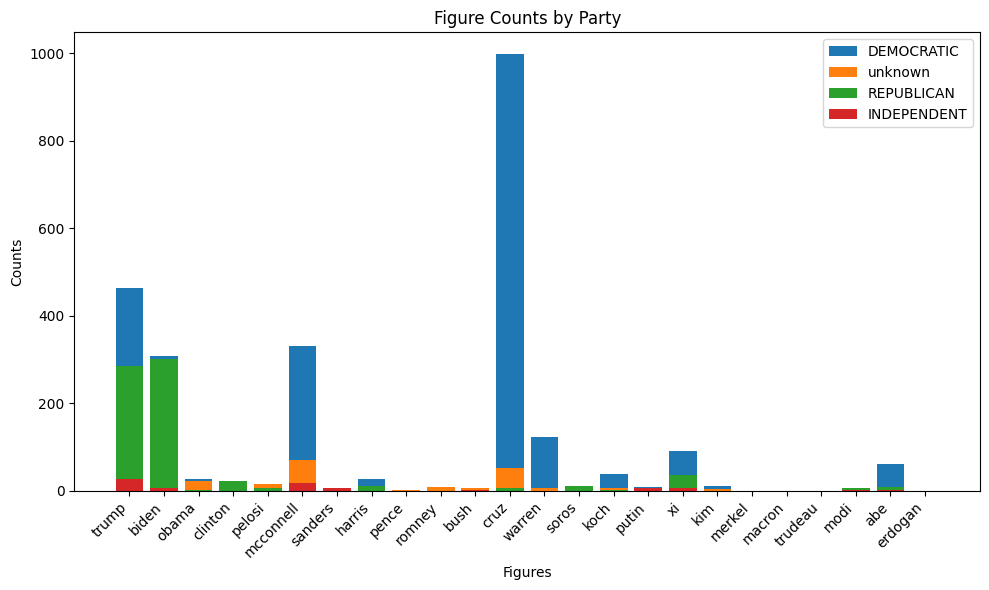

In [50]:
# Load the JSON data
with open('../data/emails_extracted.json', 'r') as file:
    data = json.load(file)

# Aggregate word and figure counts by party
word_counts_by_party = {}
figure_counts_by_party = {}

for item in data:
    party = item['party']
    if party not in word_counts_by_party:
        word_counts_by_party[party] = {}
        figure_counts_by_party[party] = {}

    for word, count in item['word_counts'].items():
        if word not in word_counts_by_party[party]:
            word_counts_by_party[party][word] = 0
        word_counts_by_party[party][word] += count

    for figure, count in item['figure_counts'].items():
        if figure not in figure_counts_by_party[party]:
            figure_counts_by_party[party][figure] = 0
        figure_counts_by_party[party][figure] += count

# Plotting

## Word Counts by Party
plt.figure(figsize=(10, 6))
for party, counts in word_counts_by_party.items():
    plt.bar(counts.keys(), counts.values(), label=party)
plt.title('Word Counts by Party')
plt.ylabel('Counts')
plt.xlabel('Words')
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.savefig('../result/word_counts_by_party.png')
plt.show()

## Figure Counts by Party
plt.figure(figsize=(10, 6))
for party, counts in figure_counts_by_party.items():
    plt.bar(counts.keys(), counts.values(), label=party)
plt.title('Figure Counts by Party')
plt.ylabel('Counts')
plt.xlabel('Figures')
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.savefig('../result/figure_counts_by_party.png')
plt.show()


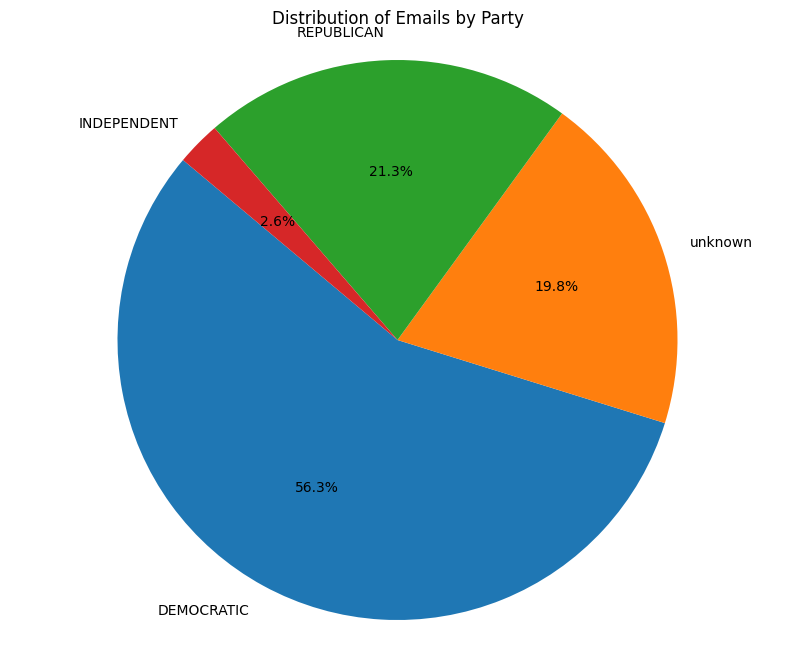

In [53]:
from collections import Counter
import matplotlib.pyplot as plt

# Example assuming 'data' is your loaded JSON data
party_counts = Counter(item['party'] for item in data)

# Plotting
plt.figure(figsize=(10, 8))
plt.pie(list(party_counts.values()), labels=list(party_counts.keys()), autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Ensures pie chart is a circle
plt.title('Distribution of Emails by Party')
plt.savefig('../result/party_distribution_pie_chart.png')
plt.show()


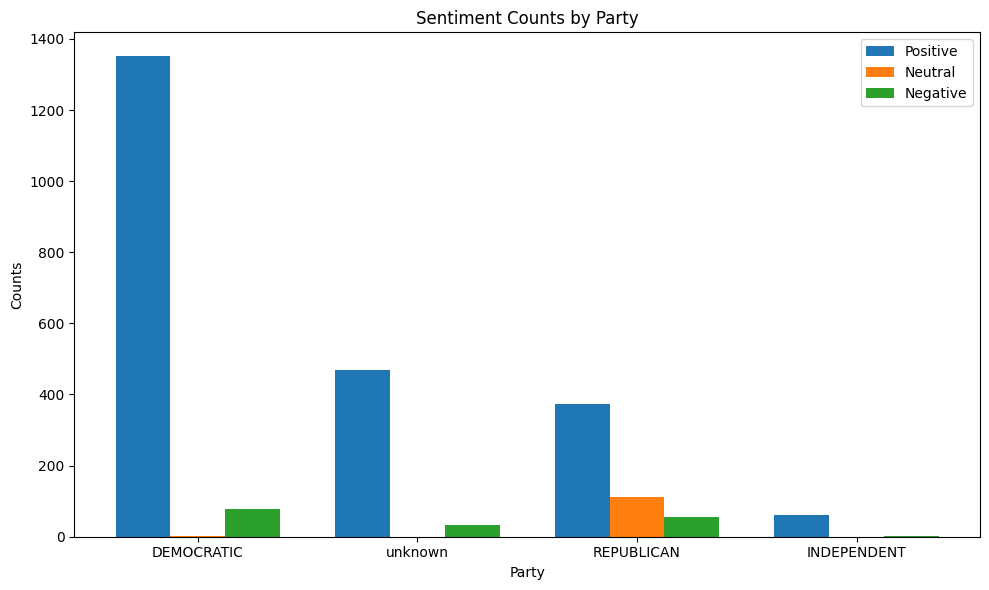

In [55]:
# Assuming 'data' is the loaded JSON data and includes a 'party' and 'content_sentiment' for each entry

# First, we'll count the sentiments for each party
sentiment_counts_by_party = {}

for item in data:
    party = item['party']
    sentiment = item['content_sentiment']
    if party not in sentiment_counts_by_party:
        sentiment_counts_by_party[party] = {'positive': 0, 'neutral': 0, 'negative': 0}
    
    # Increment the count for the sentiment for this party
    sentiment_counts_by_party[party][sentiment] += 1

# Now we'll prepare the data for plotting
parties = sentiment_counts_by_party.keys()
positive_counts = [sentiment_counts_by_party[party]['positive'] for party in parties]
neutral_counts = [sentiment_counts_by_party[party]['neutral'] for party in parties]
negative_counts = [sentiment_counts_by_party[party]['negative'] for party in parties]

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.25
index = range(len(parties))

# Create bars for each sentiment
plt.bar(index, positive_counts, bar_width, label='Positive')
plt.bar([p + bar_width for p in index], neutral_counts, bar_width, label='Neutral')
plt.bar([p + 2*bar_width for p in index], negative_counts, bar_width, label='Negative')

# Add title and labels with ticks
plt.xlabel('Party')
plt.ylabel('Counts')
plt.title('Sentiment Counts by Party')
plt.xticks([p + bar_width for p in index], parties)

plt.legend()
plt.tight_layout()
plt.savefig('../result/sentiment_counts_by_party.png')
# Show plot
plt.show()


An error occurred: 403 Client Error: Forbidden for url: https://secure.winred.com/hung-cao-for-virginia/calling-it-quits%3E
An error occurred: 403 Client Error: Forbidden for url: https://secure.winred.com/hung-cao-for-virginia/calling-it-quits%3E
An error occurred: 403 Client Error: Forbidden for url: https://secure.winred.com/hung-cao-for-virginia/calling-it-quits%3E
An error occurred: 403 Client Error: Forbidden for url: https://secure.winred.com/hung-cao-for-virginia/calling-it-quits%3E
An error occurred: 403 Client Error: Forbidden for url: https://secure.winred.com/hung-cao-for-virginia/calling-it-quits%3E
An error occurred: 403 Client Error: Forbidden for url: https://secure.winred.com/hung-cao-for-virginia/calling-it-quits%3E
An error occurred: 403 Client Error: Forbidden for url: https://secure.winred.com/hung-cao-for-virginia/calling-it-quits%3E
An error occurred: 403 Client Error: Forbidden for url: https://secure.winred.com/hung-cao-for-virginia/calling-it-quits%3E
An error

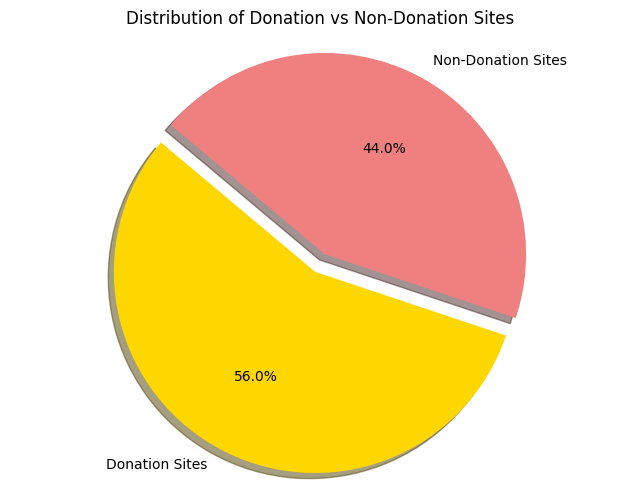

In [59]:
import requests
from bs4 import BeautifulSoup

def is_donation_site(url):
    try:
        # Fetch the webpage content
        response = requests.get(url)
        response.raise_for_status()  # Ensure the request was successful
        
        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Define a list of keywords that suggest the site is for donations
        donation_keywords = ['donate', 'contribution', 'support', 'fundraise', 'gift']
        
        # Convert the entire webpage text to lower case for case-insensitive matching
        webpage_text = soup.get_text().lower()
        
        # Check if any of the donation keywords appear in the webpage text
        for keyword in donation_keywords:
            if keyword in webpage_text:
                return True  # The site is likely a donation site
        
        # If none of the keywords were found, it's likely not a donation site
        return False
    except Exception as e:
        print(f"An error occurred: {e}")
        return False  # Unable to determine, assuming not a donation site for safety
    
# Initialize counters
donation_sites_count = 0
non_donation_sites_count = 0

# Load the JSON data from the file
with open('../data/emails_extracted.json', 'r') as file:
    emails = json.load(file)

# Iterate over URLs and count donation vs non-donation sites
for email in emails:
    for url in email["urls"]:
        result = is_donation_site(url)
        if result is True:
            donation_sites_count += 1
        elif result is False:
            non_donation_sites_count += 1
        # Skip counting if result is None (unable to determine)
            
# Data to plot
labels = 'Donation Sites', 'Non-Donation Sites'
sizes = [donation_sites_count, non_donation_sites_count]
colors = ['gold', 'lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Distribution of Donation vs Non-Donation Sites')
plt.show()


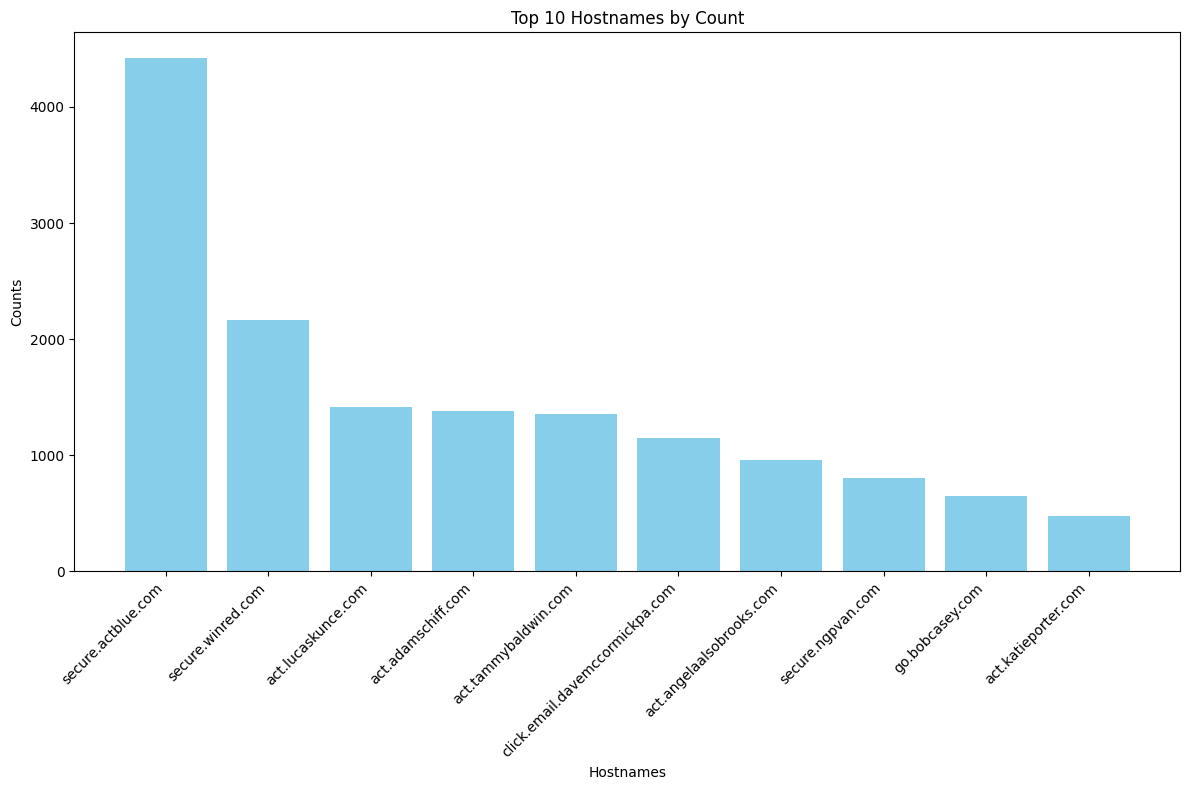

In [60]:
import json
import matplotlib.pyplot as plt

# Load the hostname counts from the JSON file
with open('../data/hostname.json', 'r') as file:
    hostname_counts = json.load(file)

# Sort the hostnames by their counts in descending order and select the top 10
top_hostnames = sorted(hostname_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Separate the hostnames and their counts for plotting
hostnames, counts = zip(*top_hostnames)

# Plotting the bar graph
plt.figure(figsize=(12, 8))
plt.bar(hostnames, counts, color='skyblue')
plt.xlabel('Hostnames')
plt.ylabel('Counts')
plt.title('Top 10 Hostnames by Count')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()
